In [89]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
import colorcet as cc
import itertools as it
import matplotlib.pyplot as plt
import numpy as np
import pyolim
import skimage.measure

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.ndimage import gaussian_filter
from skimage.transform import rescale

import common2
import marmousi

In [103]:
plt.style.use('bmh')
plt.rc('text', usetex=True)
plt.rc('font', **{
    'serif': ['Computer Modern'],
    'size': 8
})
plt.rcParams['figure.dpi'] = 144

# Make plot used in paper

## Auxiliary stuff

In [92]:
kwargs = dict(
    mode='constant',
    multichannel=False,
    anti_aliasing=False
)

p = np.inf

rel_err = lambda u, U: np.linalg.norm((u - U).flatten(), p)/np.linalg.norm(u.flatten(), p)

## First, solve 2D problems

Load scaled slowness models

In [93]:
%%time
Ss = marmousi.load_scaled_slowness()

CPU times: user 2.38 s, sys: 283 ms, total: 2.66 s
Wall time: 2.66 s


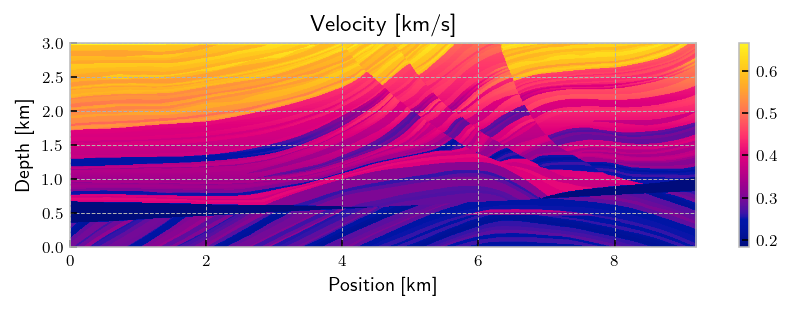

In [104]:
fig = plt.figure()
fig.set_size_inches(6.5, 2)
ax = fig.gca()
im = ax.imshow(Ss[-2], cmap=cc.cm.bmy, extent=[0, 9.2, 0, 3])
ax.set_ylabel('Depth [km]')
ax.set_xlabel('Position [km]')
ax.set_aspect('equal')
ax.set_title('Velocity [km/s]')
fig.colorbar(im, ax=ax)
fig.tight_layout()

Solve ground truth problem

In [6]:
%%time
nb = pyolim.Neighborhood.OLIM8
quad = pyolim.Quadrature.RHR
olim = marmousi.solve_point_source_problem(Ss[-1], nb, quad)
u = olim.U.copy()

CPU times: user 55.5 s, sys: 546 ms, total: 56.1 s
Wall time: 56.1 s


Set up some auxiliary functions and data structures

In [7]:
str2nb = dict(
    olim4=pyolim.Neighborhood.OLIM4,
    olim8=pyolim.Neighborhood.OLIM8
)
nbs, nb_strs = list(str2nb.values()), list(str2nb.keys())

L = np.arange(-3, 3)
N = [Ss[i].size for i in range(len(L))]
E = dict(olim4=np.empty(len(L)), olim8=np.empty(len(L)))

Solve problems

In [8]:
%%time
kmax = len(L)
for nb_str, k in it.product(nb_strs, range(kmax)):
    print(nb_str, k)
    nb = str2nb[nb_str]
    S = Ss[k]
    Ul = marmousi.solve_point_source_problem(S, nb, quad).U
    ul = rescale(u, 2**float(k - kmax), **kwargs)
    E[nb_str][k] = rel_err(ul, Ul)

olim4 0
olim4 1
olim4 2
olim4 3
olim4 4
olim4 5
olim8 0
olim8 1
olim8 2
olim8 3
olim8 4
olim8 5
CPU times: user 27.1 s, sys: 556 ms, total: 27.6 s
Wall time: 27.6 s


## Now solve 3D problems

In [50]:
def extrude_S_along_y(S, ny):
    return np.broadcast_to(S[..., None], S.shape + (ny,)).copy()

In [51]:
Ss = Ss[:4]
Ss = [rescale(Ss[0], 1/2, **kwargs)] + Ss

In [74]:
str2nb_3d = dict(
    olim6=pyolim.Neighborhood.OLIM6,
    olim26=pyolim.Neighborhood.OLIM26,
    olim3d=pyolim.Neighborhood.OLIM3D,
)

nbs_3d, nb_strs_3d = list(str2nb_3d.values()), sorted(list(str2nb_3d.keys()))
E_3d = {nb_str: np.empty(len(Ss) - 1) for nb_str in nb_strs_3d}

In [53]:
# kmin, kmax = 2, 5
# ny = int(np.ceil((257**3)/np.product(Ss[-1].shape)))

kmin, kmax = 2, 6
ny = int(np.ceil((513**3)/np.product(Ss[-1].shape)))

In [55]:
def solve(S, ny, nb, quad):
    return marmousi.solve_point_source_problem(
        extrude_S_along_y(S, ny),
        nb,
        quad
    ).U.copy()

In [58]:
%%time
nb = pyolim.Neighborhood.OLIM3D
quad = pyolim.Quadrature.RHR
u = solve(Ss[-1], ny, nb, quad)

CPU times: user 5min 40s, sys: 901 ms, total: 5min 41s
Wall time: 5min 42s


In [59]:
nys, N_3d, L = [], [], []
for k in range(kmin, kmax):
    l = k - kmax
    L.append(l)
    shape = rescale(u, 2**float(l), **kwargs).shape
    ny = shape[-1]
    nys.append(ny)
    N_3d.append(np.product(shape))

In [79]:
def solve_for_nb_str(nb_str):
    nb = str2nb_3d[nb_str]
    for i, (l, ny) in enumerate(zip(L, nys)):
        print('- i = %d (l = %d, ny = %d)' % (i, l, ny))
        ul = rescale(u, 2**float(l), **kwargs)
        Ul = solve(Ss[i], ny, nb, quad)
        E_3d[nb_str][i] = rel_err(ul, Ul)

In [80]:
for nb_str in nb_strs_3d:
    print(nb_str)
    solve_for_nb_str(nb_str)

olim26
- i = 0 (l = -4, ny = 5)
- i = 1 (l = -3, ny = 10)
- i = 2 (l = -2, ny = 20)
- i = 3 (l = -1, ny = 40)
olim3d
- i = 0 (l = -4, ny = 5)
- i = 1 (l = -3, ny = 10)
- i = 2 (l = -2, ny = 20)
- i = 3 (l = -1, ny = 40)
olim6
- i = 0 (l = -4, ny = 5)
- i = 1 (l = -3, ny = 10)
- i = 2 (l = -2, ny = 20)
- i = 3 (l = -1, ny = 40)


## Make plots

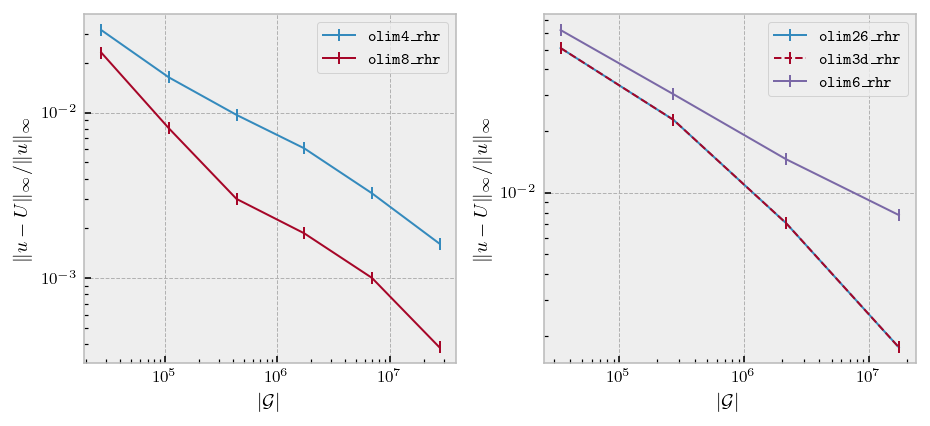

In [81]:
fig = plt.figure()
fig.set_size_inches(6.5, 3)

ax = fig.add_subplot(1, 2, 1)
ax.minorticks_off()
ax.set_ylabel(r'$\|u - U\|_\infty/\|u\|_\infty$')
ax.set_xlabel('$|\mathcal{G}|$')
for nb_str in nb_strs:
    ax.loglog(
        N, E[nb_str], marker='|', label=r'\texttt{%s\_rhr}' % nb_str,
        linewidth=1
    )
ax.legend(loc='upper right')

ax = fig.add_subplot(1, 2, 2)
ax.minorticks_off()
ax.set_ylabel(r'$\|u - U\|_\infty/\|u\|_\infty$')
ax.set_xlabel('$|\mathcal{G}|$')
for nb_str in nb_strs_3d:
    ax.loglog(
        N_3d, E_3d[nb_str], marker='|', label=r'\texttt{%s\_rhr}' % nb_str,
        linewidth=1, linestyle='--' if nb_str == 'olim3d' else '-'
    )
ax.legend(loc='upper right')

fig.tight_layout()

fig.savefig('marmousi-2d-rhr.pdf', bbox_inches='tight')